In [1]:
import itertools

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
import torch
import numpy as np
import seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader

### Importujemy potrzebne biblioteki

### autorzy: Adrian Bloch i Witold Jagiełło

In [2]:
warnings.filterwarnings("ignore")

### ignorujemy ostrzeżenia

In [3]:
X, y = make_circles(n_samples = 10000,
                    noise= 0.05,
                    random_state=26)


### Tworzymy zbiór danych o wielkości 10k

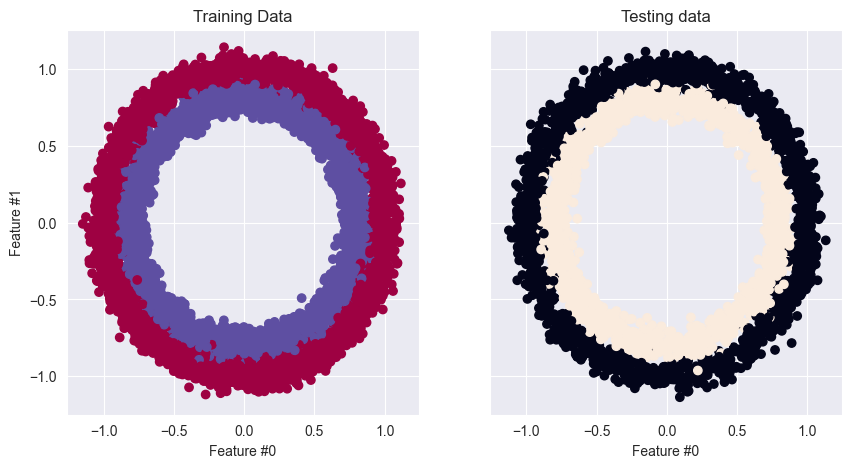

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)

fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()


### Inicjujemy dane i wielkość danych testowych w stosunku do całości oraz zamieniamy je na tensory

In [5]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

### tworzymy klasę odpowiadającą za dane w naszym zbiorze danych

In [6]:
batch_size = 64

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

### nadajemy wielkość oraz tworzymy dane treningowe i testowe

In [7]:
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch + 1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


### Wyświetlamy dane

In [8]:
input_dim = 2
hidden_dim = 10
output_dim = 1

### inicjujemy zmienne

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x


### tworzymy klasę odpowiadającą za sieć neuronową

In [10]:

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

learning_rate = 0.1
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 100
loss_values = []

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


### Ze względu na brak treningu nie musimy obliczać gradientu

In [11]:
for epoch in range(num_epochs):
    for X, y in train_dataloader:

        optimizer.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


### zerujemy gradient i kończymy treing

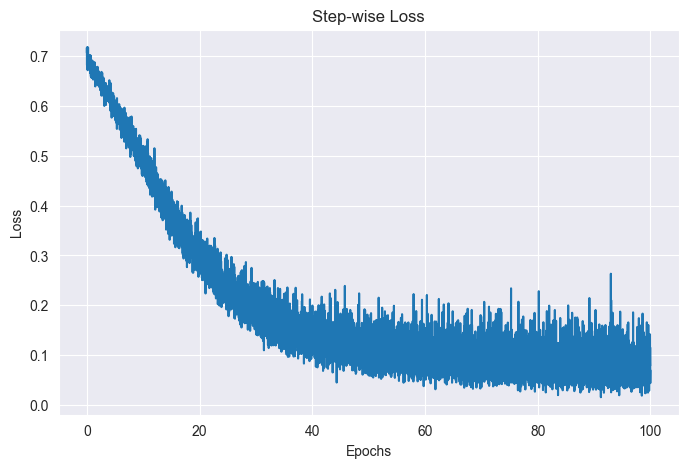

Accuracy of the network on the 3300 test instances: 98%
[[1595   40]
 [  23 1642]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1635
         1.0       0.98      0.99      0.98      1665

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



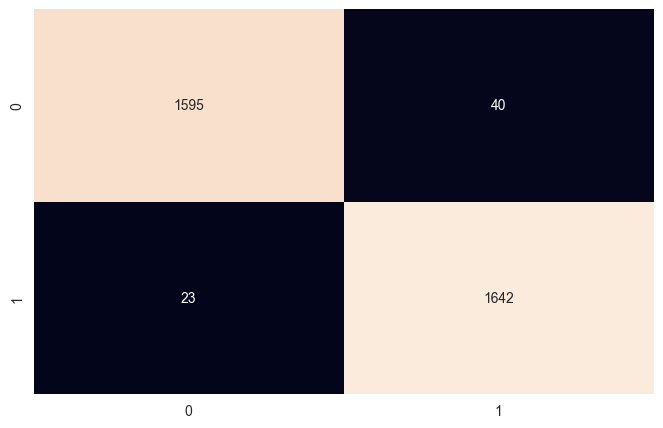

In [12]:
step = np.linspace(0, 100, 10500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

correct = 0
total = 0
y_pred = []
y_test = []

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))


cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)
print(classification_report(y_test, y_pred))

plt.subplots(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")
plt.show()

## Tworzymy wykresy oraz obliczamy dokładność sieci